In [11]:
from itertools import product
import warnings
import numpy as np
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from qutip import (Qobj,
                   sigmax,
                   identity,
                   destroy,
                   expect,
                   basis,
                   ket2dm,
                   tensor,
                   )
from qsextra import ExcitonicSystem, ChromophoreSystem
from qsextra.tools import spectral_function

In [12]:
def unit_converter(quantity: float,
                   initial_unit: str,
                   final_unit: str
                   ) -> float:
    h_bar = 0.658212
    accepted_units = ['ev', 'ev-1', 'fs', 'fs-1']
    initial_unit = initial_unit.casefold()
    final_unit = final_unit.casefold()
    if initial_unit not in accepted_units or final_unit not in accepted_units:
        raise ValueError('Invalid units')
    if initial_unit[0:2] == final_unit[0:2]:
        return 1. / quantity
    if initial_unit[-2:] == '-1':
        final_quantity = quantity * h_bar
        if final_unit[-2:] == '-1':
            return 1. / final_quantity
        return final_quantity
    else:
        final_quantity = quantity / h_bar
        if final_unit[-2:] != '-1':
            return 1. / final_quantity
        return final_quantity

In [13]:
class Spectroscopy:

    @property
    def label(self) -> str:
        return self._label

    @label.setter
    def label(self, label: str):
        self._label = label

    @property
    def delay_time(self) -> list[list]:
        return self._delay_time

    @delay_time.setter
    def delay_time(self, delays):
        if np.isscalar(delays):
            dys = [[delays]]
        elif isinstance(delays, np.ndarray):
            dys = [delays.tolist()]
        elif isinstance(delays, list):
            dys = []
            for delay in delays:
                if np.isscalar(delay):
                    dy = [delay]
                elif isinstance(delay, np.ndarray):
                    dy = delay.tolist()
                elif isinstance(delay, list):
                    dy = delay
                dys.append(dy)
        else:
            raise TypeError('Invalid delay time type')
        self._delay_time = dys

    @property
    def side_seq(self) -> str:
        return self._side_seq

    @side_seq.setter
    def side_seq(self, side_sequence):
        self._side_seq = side_sequence

    @property
    def direction_seq(self) -> str:
        return self._direction_seq

    @direction_seq.setter
    def direction_seq(self, direction_sequence):
        self._direction_seq = direction_sequence

    def __init__(self,
                 delay_time: np.ndarray | list[list[float]] | list[float] | float,
                 label: str = '',
                 ):
        self.label = label
        self.delay_time = delay_time
        self.side_seq = ''
        self.direction_seq = ''

    def todict(self) -> dict:
        init_dict = self.__dict__
        sp_dict = {'class': self.__class__.__name__}
        for key in init_dict:
            new_key = key if key[0] != '_' else key[1:]
            sp_dict[new_key] = init_dict[key]
            if isinstance(init_dict[key], np.ndarray):
                sp_dict[new_key] = init_dict[key].tolist()
        return sp_dict


class FeynmanDiagram(Spectroscopy):
    _linear_list = ['a', 'abs']
    _thirdorder_list = ['gsb', 'se', 'esa']

    def __init__(self,
                 FD_label: str,
                 delay_time: float | list[float] | np.ndarray | list[np.ndarray] | list[list[float]],
                 ):
        self.set(FD_label, delay_time)

    def set(self,
            FD_label: str,
            delay_time: float | list[float] | np.ndarray | list[np.ndarray] | list[list[float]],
            ):
        if not isinstance(FD_label, str):
            raise TypeError('FD_label must be a string')
        FD_label = FD_label.casefold()
        if FD_label not in self._linear_list + self._thirdorder_list:
            raise ValueError('Invalid Feynman diagram label')
        self.label = FD_label

        self.delay_time = delay_time
        if self.label in self._linear_list:
            if len(self.delay_time) != 1:
                raise ValueError('Invalid number of delay times. Expected 1')
        if self.label in self._thirdorder_list:
            if len(self.delay_time) != 3:
                raise ValueError('Invalid number of delay times. Expected 3')

        self.__FD_to_sequence()

    def __FD_to_sequence(self):
        if self.label in ('a', 'abs'):
            self.side_seq = 'kk'
            self.direction_seq = 'io'
        elif self.label == 'gsb':
            self.side_seq = 'bbkk'
            self.direction_seq = 'ioio'
        elif self.label == 'se':
            self.side_seq = 'bkbk'
            self.direction_seq = 'iioo'
        elif self.label == 'esa':
            self.side_seq = 'bkkk'
            self.direction_seq = 'iiio'

In [14]:
from qsextra.qcomo import clevolve


def clspectroscopy(system: ChromophoreSystem | ExcitonicSystem,
                   spectroscopy: Spectroscopy,
                   verbose: bool = True,
                   **clevolve_kwds,
                   ) -> np.ndarray:
    if type(system) is ChromophoreSystem and system.mode_dict is None:
        system = system.extract_ExcitonicSystem()
        return clspectroscopy(system, spectroscopy, verbose, **clevolve_kwds)

    clevolve_kwds.pop('system', None)
    clevolve_kwds.pop('time', None)
    clevolve_kwds.pop('measure_populations', None)
    clevolve_kwds.pop('state_overwrite', None)
    clevolve_kwds.pop('verbose', None)

    if spectroscopy.side_seq == '' or spectroscopy.direction_seq == '':
        raise ValueError('Spectroscopy object not properly initialized')

    signal = __clrun(system, spectroscopy, clevolve_kwds)
    if verbose:
        print(f'{spectroscopy.label.upper()} spectroscopy calculated')
    return signal


def __clrun(system: ChromophoreSystem | ExcitonicSystem,
            spectroscopy: Spectroscopy,
            clevolve_kwds: dict = {},
            ) -> np.ndarray:

    def combinations(size: list[int]):
        return list(product(*[range(s) for s in size]))

    def dipole_operator(spectroscopy: Spectroscopy,
                        first_k: bool,
                        first_b: bool,
                        n_interaction: int,
                        ):
        sx = sigmax()
        sm = destroy(2)
        sp = sm.dag()

        side = spectroscopy.side_seq[n_interaction]
        direction = spectroscopy.direction_seq[n_interaction]
        if side == 'b' and first_b:
            dipole_op = sx
            first_b = False
        elif side == 'k' and first_k:
            dipole_op = sx
            first_k = False
        else:
            dipole_op = sm if (side == 'k') ^ (direction == 'i') else sp
        return dipole_op, first_k, first_b

    def build_operator(N: int,
                       site_index: int,
                       operator: Qobj,
                       Id_pseudomodes: list[Qobj] = None,
                       ):
        I = identity(2)
        if not Id_pseudomodes:
            return tensor(*[I] * (N-site_index-1), operator, *[I]*site_index)
        return tensor(*[I] * (N-site_index-1), operator, *[I]*site_index, *Id_pseudomodes*N)

    def dipole_application(dm: Qobj,
                           dipole_op: Qobj,
                           side: str,
                           ):
        if side == 'b':
            dm_output = dm * dipole_op
        else:
            dm_output = dipole_op * dm
        return dm_output

    N = system.system_size
    sx = sigmax()

    state_0 = basis([2]*N, [0]*N)
    if type(system) is ChromophoreSystem:
        W = len(system.mode_dict['omega_mode'])
        d = system.mode_dict['lvl_mode']
        Id_pseudomodes = [identity(d[k]) for k in range(W)]
        state_modes = system.get_state_mode()
        state_0 = tensor(state_0, *[state_modes[k] for k in range(W)] * N)
    else:
        Id_pseudomodes = None

    e_op_list = [system.dipole_moments[i] *
                 build_operator(N, i, sx, Id_pseudomodes) for i in range(N)]

    size_signal = [len(T) for T in spectroscopy.delay_time]
    signal = np.zeros(size_signal, dtype=complex)
    time_indices = combinations(size_signal)

    site_pathways_indices = combinations([N] * len(spectroscopy.delay_time))

    for indices in site_pathways_indices:
        for time in time_indices:
            first_k = True
            first_b = True
            dm = ket2dm(state_0)
            for n, interaction in enumerate(indices):
                dipole_op, first_k, first_b = dipole_operator(spectroscopy,
                                                              first_k,
                                                              first_b,
                                                              n,
                                                              )
                dipole_op = build_operator(N,
                                           interaction,
                                           dipole_op,
                                           Id_pseudomodes,
                                           )
                side = spectroscopy.side_seq[n]
                dm = dipole_application(dm, dipole_op, side)
                try:
                    results = clevolve(system,
                                       [0, spectroscopy.delay_time[n][time[n]]],
                                       measure_populations=False,
                                       state_overwrite=dm,
                                       verbose=False,
                                       **clevolve_kwds,
                                       )
                except:
                    results = clevolve(system,
                                       spectroscopy.delay_time[n][0:time[n]+1],
                                       measure_populations=False,
                                       state_overwrite=dm,
                                       verbose=False,
                                       **clevolve_kwds,
                                       )
                dm = results.states[-1]
            signal[*time] += (np.sum(expect(e_op_list, dm)) *
                              np.prod([system.dipole_moments[i] for i in indices]))

    return signal

In [15]:
from itertools import chain
from qiskit import AncillaRegister, QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, DensityMatrix
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendEstimator
from jqme.qcomo import qevolve


def qspectroscopy(system: ChromophoreSystem | ExcitonicSystem,
                  spectroscopy: Spectroscopy,
                  shots: int = 1000,
                  verbose: bool = True,
                  **qevolve_kwds,
                  ) -> np.ndarray:
    if type(system) is ChromophoreSystem and system.mode_dict is None:
        warnings.warn(
            'Pseudomodes not specified. Extracting ExcitonicSystem object')
        system = system.extract_ExcitonicSystem()
        return qspectroscopy(system,
                             spectroscopy,
                             shots,
                             verbose,
                             qevolve_kwds,
                             )

    qevolve_kwds.pop('system', None)
    qevolve_kwds.pop('time', None)
    qevolve_kwds.pop('shots', None)
    qevolve_kwds.pop('initialize_circuit', None)
    qevolve_kwds.pop('verbose', None)

    if spectroscopy.side_seq == '' or spectroscopy.direction_seq == '':
        raise ValueError('Spectroscopy object not properly initialized')

    signal = __qrun(system,
                    spectroscopy,
                    shots,
                    qevolve_kwds,
                    )
    if verbose:
        print(f'{spectroscopy.label.upper()} spectroscopy calculated')
    return signal


def __qrun(system: ChromophoreSystem | ExcitonicSystem,
           spectroscopy: Spectroscopy,
           shots: int,
           qevolve_kwds: dict = {},
           ) -> np.ndarray:

    def combinations(size: list[int]):
        return list(product(*[range(s) for s in size]))

    def qc_dipole_application(qc: QuantumCircuit,
                              qr_kb: QuantumRegister,
                              qr_e: QuantumRegister,
                              site: int,
                              side: str,
                              op: str,
                              ):
        if side == 'b':
            qc.x(qr_kb[0])
        if op == 'X':
            qc.cx(qr_kb[0], qr_e[site])
        elif op == 'Y':
            qc.cy(qr_kb[0], qr_e[site])
        if side == 'b':
            qc.x(qr_kb[0])
        return qc

    N = system.system_size

    bool_ancillae = (qevolve_kwds.get('coll_rates') is not None)
    qc_og, qr_kb, qr_e = __create_circuit(system, bool_ancillae)
    qc_og.h(qr_kb[0])

    # Defining the expectation operators on the ketbra ancilla
    n_qubits = len(qc_og.qubits)
    e_op = [SparsePauliOp('I'*(n_qubits-1) + 'X'),
            SparsePauliOp('I'*(n_qubits-1) + 'Y')]

    # Defining the output variable (signal)
    delay_time = spectroscopy.delay_time
    size_signal = [len(T) for T in delay_time]
    signal = np.zeros(size_signal, dtype=complex)
    time_indices = combinations(size_signal)
    site_pathways_indices = combinations([N] * (len(delay_time)+1))

    total_count = (len(list(chain(*time_indices)))
                   * len(list(chain(*site_pathways_indices))))
    count = 0
    for time in time_indices:
        qc_mega_list = []
        coeff_mega_list = []
        for site_pathways in site_pathways_indices:
            first_k = True
            first_b = True
            last_op = False
            qc_list = [qc_og.copy()]
            coeff_list = [1.]
            for n, interaction in enumerate(site_pathways):
                count += 1
                print(f'{count}/{total_count}', end='\r', flush=True)
                if n == len(site_pathways)-1:
                    last_op = True
                    qc_evo = QuantumCircuit(n_qubits - 1)
                else:
                    qc_evo = qevolve(system,
                                     delay_time[n][time[n]],
                                     shots=None,
                                     initialize_circuit=False,
                                     verbose=False,
                                     **qevolve_kwds,
                                     )[0]
                qc_new_list = []
                coeff_new_list = []
                for n_qc, qc in enumerate(qc_list):
                    side = spectroscopy.side_seq[n]
                    direction = spectroscopy.direction_seq[n]
                    if side == 'b' and first_b:
                        qc_new = qc_dipole_application(qc.copy(),
                                                       qr_kb,
                                                       qr_e,
                                                       interaction,
                                                       side,
                                                       'X',
                                                       )
                        qc_new.compose(qc_evo,
                                       qubits=range(1, n_qubits),
                                       inplace=True,
                                       )
                        qc_new_list.append(qc_new)
                        coeff_new_list.append(coeff_list[n_qc]
                                              * system.dipole_moments[interaction])
                        first_b = False
                    elif side == 'k' and first_k:
                        qc_new = qc_dipole_application(qc.copy(),
                                                       qr_kb,
                                                       qr_e,
                                                       interaction,
                                                       side,
                                                       'X',
                                                       )
                        qc_new.compose(qc_evo,
                                       qubits=range(1, n_qubits),
                                       inplace=True,
                                       )
                        qc_new_list.append(qc_new)
                        coeff_new_list.append(coeff_list[n_qc]
                                              * system.dipole_moments[interaction])
                        first_k = False
                    elif last_op:
                        qc_new = qc_dipole_application(qc.copy(),
                                                       qr_kb,
                                                       qr_e,
                                                       interaction,
                                                       side,
                                                       'X',
                                                       )
                        qc_new_list.append(qc_new)
                        coeff_new_list.append(coeff_list[n_qc]
                                              * system.dipole_moments[interaction])
                    else:
                        for op in ['X', 'Y']:
                            qc_new = qc_dipole_application(qc.copy(),
                                                           qr_kb,
                                                           qr_e,
                                                           interaction,
                                                           side,
                                                           op,
                                                           )
                            qc_new.compose(qc_evo,
                                           qubits=range(1, n_qubits),
                                           inplace=True,
                                           )
                            qc_new_list.append(qc_new)
                            if op == 'X':
                                factor = 1/2
                            elif (side == 'k') ^ (direction == 'i'):
                                factor = 1j/2
                            else:
                                factor = -1j/2
                            coeff_new_list.append(coeff_list[n_qc]
                                                  * system.dipole_moments[interaction]
                                                  * factor)
                qc_list = qc_new_list
                coeff_list = coeff_new_list
            qc_mega_list += qc_list
            coeff_mega_list += coeff_list

        if not shots:
            results_X, results_Y = [], []
            for qc in qc_mega_list:
                density_matrix = DensityMatrix(qc)
                results_X.append(density_matrix.expectation_value(e_op[0]))
                results_Y.append(density_matrix.expectation_value(e_op[1]))
            results_X = np.array(results_X)
            results_Y = np.array(results_Y)
        else:
            backend = AerSimulator(shots=shots)
            estimator = BackendEstimator(backend)

            results_X = estimator.run(qc_mega_list,
                                      [e_op[0]]*len(qc_mega_list)
                                      ).result().values
            results_Y = estimator.run(qc_mega_list,
                                      [e_op[1]]*len(qc_mega_list)
                                      ).result().values
        results = results_X + 1j * results_Y
        signal[*time] += np.sum(results * np.array(coeff_mega_list))
    return signal


def __create_circuit(system: ChromophoreSystem | ExcitonicSystem,
                     bool_ancillae: bool,
                     ):
    register_list = []
    qr_kb = AncillaRegister(1, 'ketbra')
    register_list.append(qr_kb)

    qr_e = QuantumRegister(system.system_size, 'sys_e')
    register_list.append(qr_e)

    if type(system) is ChromophoreSystem:
        qr_p_list = []
        for i in range(system.system_size):
            for k, d_k in enumerate(system.mode_dict['lvl_mode']):
                n_qubits = int(np.log2(d_k))
                qr_p_list.append(QuantumRegister(n_qubits, f'mode({i},{k})'))
        register_list += qr_p_list

    if bool_ancillae:
        qr_a = AncillaRegister(1, 'a')
        register_list.append(qr_a)

    cr = ClassicalRegister(1)
    register_list.append(cr)
    qc = QuantumCircuit(*register_list)
    return qc, qr_kb, qr_e

In [16]:
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift


def postprocessing(spectroscopy: Spectroscopy,
                   signal: np.ndarray,
                   RF_freq: float = 0,
                   damping_rate: float = 0,
                   pad_extension: int = 1,
                   T2_index: int = 0,
                   ):
    response_function = signal
    delay_time = spectroscopy.delay_time

    RF_response_function = rotating_frame(response_function,
                                          delay_time,
                                          RF_freq,
                                          damping_rate,
                                          T2_index,
                                          )
    omega, freq_spectrum = fourier_transform(RF_response_function,
                                             delay_time,
                                             RF_freq,
                                             T2_index,
                                             pad_extension,
                                             )
    return omega, freq_spectrum


def rotating_frame(response_function,
                   delay_time,
                   RF_freq,
                   damping_rate,
                   T2_index,
                   ):
    if len(delay_time) == 1:
        return __linear_rf(response_function, delay_time, RF_freq, damping_rate)
    elif len(delay_time) == 3:
        return __2D_rf(response_function, delay_time, RF_freq, damping_rate, T2_index)
    return NotImplementedError('Rotating frame not implemented for this spectroscopy')


def __linear_rf(response_function,
                delay_time,
                RF_freq,
                damping_rate,
                ):
    T = np.array(delay_time[0])
    rf_response_function = (response_function
                            * np.exp(+1j * RF_freq * T)
                            * np.exp(-damping_rate * T))
    return rf_response_function


def __2D_rf(response_function,
            delay_time,
            RF_freq,
            damping_rate,
            T2_index,
            ):
    T1 = np.array(delay_time[0])
    T2 = np.array(delay_time[1])
    T3 = np.array(delay_time[2])
    if T2_index > len(T2):
        raise ValueError('Invalid T2 index')
    T1, T3 = np.meshgrid(T1, T3, indexing='ij')
    rf_response_function = (response_function[:, T2_index, :]
                            * np.exp(-1j * RF_freq * (T1 - T3))
                            * np.exp(-damping_rate * (T1 + T3)))
    return rf_response_function


def fourier_transform(response_function,
                      delay_time,
                      RF_freq,
                      T2_index,
                      pad_extension,
                      ):
    if len(delay_time) == 1:
        return __linear_ft(response_function, delay_time, RF_freq, pad_extension)
    elif len(delay_time) == 3:
        return __2D_ft(response_function, delay_time, RF_freq, T2_index, pad_extension)
    return NotImplementedError('Fourier transform not implemented for this spectroscopy')


def __linear_ft(response_function,
                delay_time,
                RF_freq,
                pad_extension,
                ):
    delay_time = delay_time[0]
    dt = delay_time[1] - delay_time[0]

    n_points = len(delay_time) * pad_extension
    freq_axis = fftfreq(n_points, dt)
    omega = fftshift(2 * np.pi * freq_axis) + RF_freq
    response_function_pad = np.pad(response_function,
                                   (0, n_points - len(delay_time)),
                                   'constant',
                                   )
    freq_spectra = ifftshift(ifft(response_function_pad))
    return omega, freq_spectra


def __2D_ft(response_function,
            delay_time,
            RF_freq,
            T2_index,
            pad_extension,
            ):
    T1 = delay_time[0]
    dt1 = T1[1] - T1[0]
    T2 = delay_time[1]
    T3 = delay_time[2]
    dt3 = T3[1] - T3[0]
    if T2_index > len(T2):
        raise ValueError('Invalid T2 index')

    omega1 = fftshift(2*np.pi*fftfreq(len(T1) * pad_extension, dt1)) + RF_freq
    omega3 = fftshift(2*np.pi*fftfreq(len(T3) * pad_extension, dt3)) + RF_freq
    omega1, omega3 = np.meshgrid(omega1, omega3, indexing='ij')
    omega = [omega1, omega3]

    response_function_pad = np.pad(response_function,
                                   ((0, len(T1)*(pad_extension-1)),
                                    (0, len(T3)*(pad_extension-1))),
                                   'constant',
                                   )
    normalization = len(response_function_pad)/len(response_function)**2
    fft_spec_0 = fftshift(fft(response_function_pad, axis=0), axes=0)
    fft_spec_1 = fftshift(ifft(fft_spec_0, axis=1), axes=1)
    freq_spectra = normalization * fft_spec_1
    return omega, freq_spectra

#### **Absorption Spectrum**

##### **Excitonic System**

In [17]:
epsilon = [1.55, 1.46]    # [eV]
J = toeplitz([0., -0.01])    # [eV]
N = len(epsilon)

In [18]:
esys = ExcitonicSystem(energies=epsilon,
                       dipole_moments=[1.] * N,
                       couplings=J,
                       )

In [19]:
dt_fs = 0.1
t_final = 100.
t_list_plot = np.arange(0., t_final + dt_fs, dt_fs)
t_list = unit_converter(t_list_plot, initial_unit='fs', final_unit='eV-1')
dt = t_list[1] - t_list[0]
times_plot = np.arange(0., t_final + dt_fs, 100 * dt_fs)
times = unit_converter(times_plot, initial_unit='fs', final_unit='eV-1')
print(times)

Gamma = 59.08 * 10**(-3)

spec = FeynmanDiagram('a', times)

[  0.          15.19267349  30.38534697  45.57802046  60.77069394
  75.96336743  91.15604091 106.3487144  121.54138788 136.73406137
 151.92673485]


In [20]:
shots = None

signal_ex_q = qspectroscopy(esys,
                            spec,
                            shots=shots,
                            coll_rates=Gamma/4,
                            dt=dt,
                            )
signal_ex = clspectroscopy(esys, spec, rates=Gamma/4)

A spectroscopy calculated
A spectroscopy calculated


In [21]:
freq, spectrum_ex_q = postprocessing(spec,
                                     signal_ex_q,
                                     pad_extension=3,
                                     RF_freq=1.505,
                                     )

freq, spectrum_ex = postprocessing(spec,
                                   signal_ex,
                                   pad_extension=3,
                                   RF_freq=1.505,
                                   )

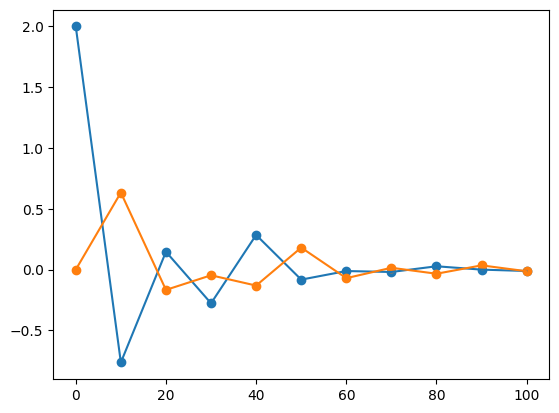

In [22]:
plt.scatter(times_plot, signal_ex_q.real)
plt.scatter(times_plot, signal_ex_q.imag)

plt.plot(times_plot, signal_ex.real)
plt.plot(times_plot, signal_ex.imag)

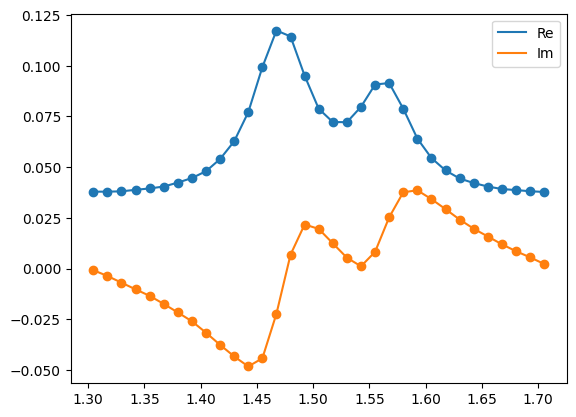

In [23]:
plt.scatter(freq, spectrum_ex_q.real)
plt.scatter(freq, spectrum_ex_q.imag)

plt.plot(freq, spectrum_ex.real, label='Re')
plt.plot(freq, spectrum_ex.imag, label='Im')

plt.legend()

##### **Choromophore system**

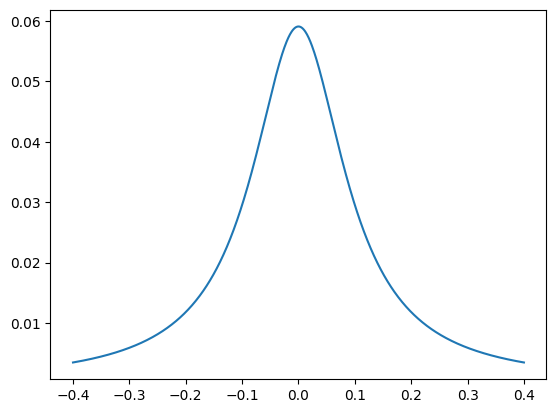

In [ ]:
sys = ChromophoreSystem(excitonic_system=esys)
W = 1
frequencies_pseudomode = [0] * W
Gamma_list = [Gamma / W] * W
Omega_list = [0.1] * W
fr, sf = spectral_function(frequencies_pseudomode, Gamma_list, Omega_list)
plt.plot(fr, sf)

In [ ]:
sys.pseudomodes(frequencies_pseudomode=frequencies_pseudomode,
                levels_pseudomode=[2]*len(frequencies_pseudomode),
                couplings_ep=np.sqrt(np.array(Gamma_list)
                                     * np.array(Omega_list)/2).tolist(),
                )
coll_rate = (2 * np.array(Omega_list)).tolist()

In [ ]:
shots = None

signal_ch_q = qspectroscopy(sys,
                            spec,
                            shots=shots,
                            coll_rates=coll_rate,
                            dt=dt,
                            )

signal_ch = clspectroscopy(sys, spec, rates=coll_rate)

A spectroscopy calculated
A spectroscopy calculated


In [ ]:
freq, spectrum_ch_q = postprocessing(spec,
                                     signal_ch_q,
                                     pad_extension=3,
                                     RF_freq=1.505,
                                     )
freq, spectrum_ch = postprocessing(spec,
                                   signal_ch,
                                   pad_extension=3,
                                   RF_freq=1.505,
                                   )

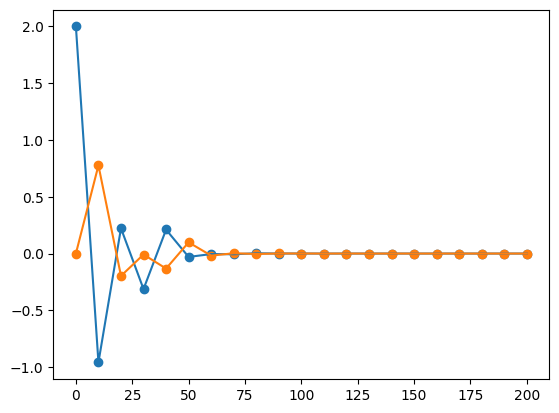

In [ ]:
plt.scatter(times_plot, signal_ch_q.real)
plt.scatter(times_plot, signal_ch_q.imag)

plt.plot(times_plot, signal_ch.real)
plt.plot(times_plot, signal_ch.imag)

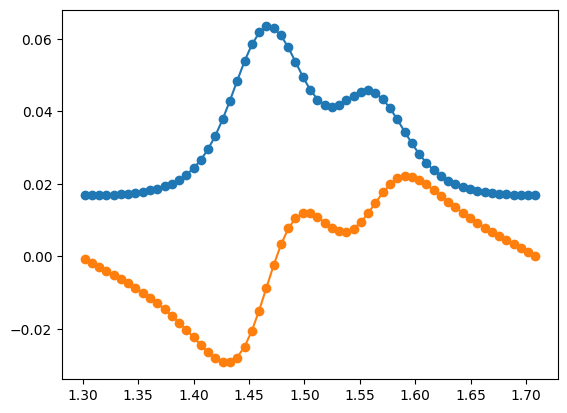

In [ ]:
plt.scatter(freq, spectrum_ch_q.real)
plt.scatter(freq, spectrum_ch_q.imag)

plt.plot(freq, spectrum_ch.real)
plt.plot(freq, spectrum_ch.imag)

##### **Comparison**

Text(0, 0.5, 'amplitude (a.u.)')

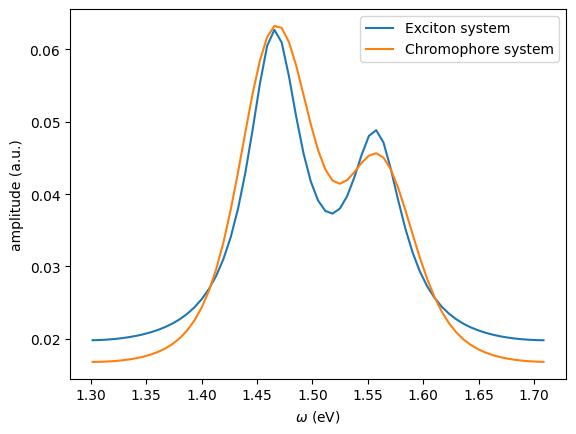

In [ ]:
plt.plot(freq, spectrum_ex.real, label='Exciton system')
plt.plot(freq, spectrum_ch.real, label='Chromophore system')
plt.legend()
plt.xlabel(r'$\omega$ (eV)')
plt.ylabel(r'amplitude (a.u.)')

#### **GSB spectrum**

In [7]:
epsilon = [1.55, 1.46]    # [eV]
J = toeplitz([0., -0.01])    # [eV]
N = len(epsilon)

In [8]:
esys = ExcitonicSystem(energies=epsilon,
                       dipole_moments=[1.] * N,
                       couplings=J,
                       )

eigvals, _ = np.linalg.eig(esys.get_e_Hamiltonian().full())
eigvals -= np.min(eigvals)

In [9]:
dt_fs = 0.1    # [fs]
t_final = 200.    # [fs]
t_list_plot = np.arange(0, t_final + dt_fs, dt_fs)    # [fs]
# Now convert to eV^-1
t_list = unit_converter(t_list_plot, initial_unit='fs',
                        final_unit='eV-1')    # [eV-1]
dt = t_list[1] - t_list[0]    # [eV-1]
# For the quantum execution we reduce the time list in order to save computational time
times_plot = np.arange(0, t_final + dt_fs, 100 * dt_fs)    # [fs]
times = unit_converter(times_plot, initial_unit='fs',
                       final_unit='eV-1')    # [eV-1]

t2_plot = np.array([0])    # [fs]
t2 = unit_converter(t2_plot, initial_unit='fs', final_unit='eV-1')    # [eV-1]

three_t_list = [times, t2, times]

Gamma = 59.08 * 10**(-3)

spec = FeynmanDiagram('gsb', three_t_list)

##### **Excitonic System**

In [ ]:
signal_ex_q = qspectroscopy(esys,
                            spec,
                            shots=shots,
                            coll_rates=Gamma / 4,
                            dt=dt,
                            )
signal_ex = clspectroscopy(esys, spec, rates=Gamma)

In [ ]:
freq, spectrum_ex_q = postprocessing(spec,
                                     signal_ex_q,
                                     pad_extension=3,
                                     RF_freq=1.505,
                                     )
freq, spectrum_ex = postprocessing(spec,
                                   signal_ex,
                                   pad_extension=3,
                                   RF_freq=1.505,
                                   )

In [ ]:
plt.imshow(signal_ex_q[:, 0, :].real)

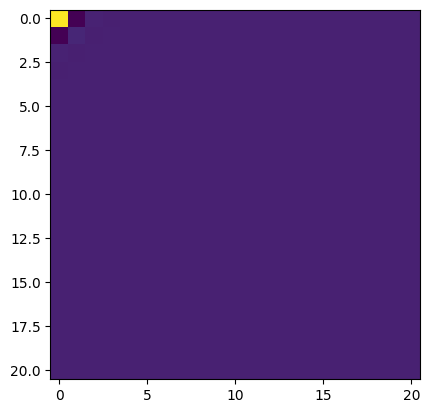

In [ ]:
plt.imshow(signal_ex[:, 0, :].real)

In [ ]:
vmin = spectrum_ex_q.real.min()
vmax = spectrum_ex_q.real.max()
v = max(np.abs(vmin), vmax)
plt.plot(np.diag(freq[0]), np.diag(freq[1]), linestyle='--', alpha=0.5)
plt.contour(freq[0], freq[1], spectrum_ex_q,
            colors='k', linewidths=0.5, vmin=-v, vmax=v)
plt.contourf(freq[0], freq[1], spectrum_ex_q, cmap='RdBu_r', vmin=-v, vmax=v)
[plt.axvline(x=eigval.real, linestyle='--', alpha=0.5) for eigval in eigvals]
[plt.axhline(y=eigval.real, linestyle='--', alpha=0.5) for eigval in eigvals]
plt.axis('square')
plt.xlim([1.3, 1.7])
plt.ylim([1.3, 1.7])

[[0.00703226+3.62421397e-09j 0.00705329-8.87352073e-05j
  0.00708201-1.76021350e-04j ... 0.00701499+2.70020360e-04j
  0.00701313+1.79852996e-04j 0.00701888+8.96897180e-05j]
 [0.00705329+8.87422421e-05j 0.0070755 +6.01596553e-09j
  0.00710541-8.71773819e-05j ... 0.00703257+3.59351571e-04j
  0.00703183+2.68896588e-04j 0.00703874+1.78532431e-04j]
 [0.00708201+1.76027576e-04j 0.00710541+8.71887293e-05j
  0.00713652+5.71359335e-09j ... 0.00705787+4.47519590e-04j
  0.00705825+3.56675961e-04j 0.00706629+2.66018816e-04j]
 ...
 [0.007015  -2.70008609e-04j 0.00703257-3.59329667e-04j
  0.00705786-4.47502729e-04j ... 0.00700814+8.10966177e-09j
  0.00700282-8.98617790e-05j 0.0070051 -1.80027967e-04j]
 [0.00701314-1.79851115e-04j 0.00703184-2.68882988e-04j
  0.00705825-3.56657620e-04j ... 0.00700283+8.98689433e-05j
  0.00699866+5.80574222e-09j 0.00700209-9.00579562e-05j]
 [0.00701888-8.96870782e-05j 0.00703874-1.78528507e-04j
  0.0070663 -2.66009912e-04j ... 0.00700509+1.80028478e-04j
  0.00700209+9

(1.3, 1.7)

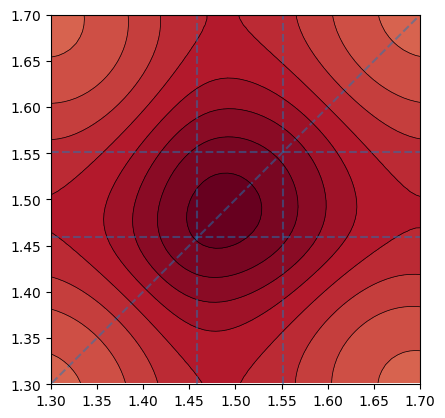

In [ ]:
vmin = spectrum_ex.real.min()
vmax = spectrum_ex.real.max()

v = max(np.abs(vmin), vmax)
plt.plot(np.diag(freq[0]), np.diag(freq[1]), linestyle='--', alpha=0.5)
plt.contour(freq[0], freq[1], spectrum_ex, colors='k',
            linewidths=0.5, vmin=-v, vmax=v)
plt.contourf(freq[0], freq[1], spectrum_ex, cmap='RdBu_r', vmin=-v, vmax=v)
[plt.axvline(x=eigval.real, linestyle='--', alpha=0.5) for eigval in eigvals]
[plt.axhline(y=eigval.real, linestyle='--', alpha=0.5) for eigval in eigvals]
plt.axis('square')
plt.xlim([1.3, 1.7])
plt.ylim([1.3, 1.7])

##### **Chormophore system**

In [10]:
sys = ChromophoreSystem(excitonic_system=esys)

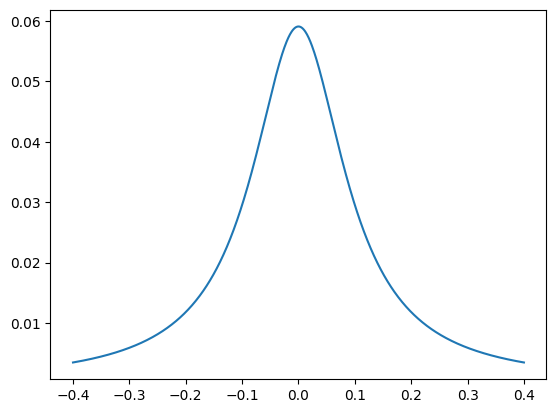

In [11]:
W = 1
frequencies_pseudomode = [0] * W
Gamma_list = [Gamma / W] * W
Omega_list = [0.1] * W
fr, sf = spectral_function(frequencies_pseudomode, Gamma_list, Omega_list)
plt.plot(fr, sf)

In [12]:
sys.pseudomodes(frequencies_pseudomode=frequencies_pseudomode,
                levels_pseudomode=[2]*len(frequencies_pseudomode),
                couplings_ep=np.sqrt(np.array(Gamma_list)
                                     * np.array(Omega_list)/2).tolist(),
                )
coll_rate = (2 * np.array(Omega_list)).tolist()

In [ ]:
shots = None

signal_ch_q = qspectroscopy(sys,
                            spec,
                            shots=shots,
                            coll_rates=coll_rate,
                            dt=dt,
                            )
signal_ch = clspectroscopy(sys, spec, rates=coll_rate)

In [4]:
freq, spectrum_ch_q = postprocessing(spec,
                                     signal_ch_q,
                                     pad_extension=3,
                                     RF_freq=1.505,
                                     )
freq, spectrum_ch = postprocessing(spec,
                                   signal_ch,
                                   pad_extension=3,
                                   RF_freq=1.505,
                                   )

NameError: name 'postprocessing' is not defined

In [ ]:
plt.imshow(signal_ch_q[:, 0, :].real)

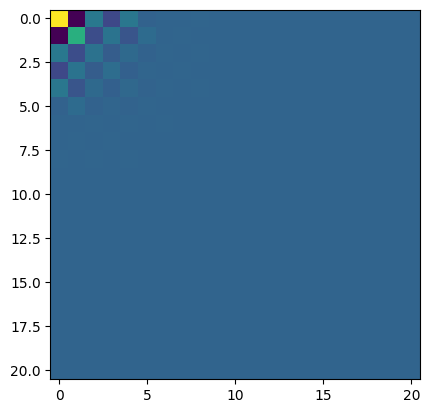

In [ ]:
plt.imshow(signal_ch[:, 0, :].real)

In [ ]:
vmin = signal_ch_q.real.min()
vmax = signal_ch_q.real.max()
v = max(np.abs(vmin), vmax)
plt.plot(np.diag(freq[0]), np.diag(freq[1]), linestyle='--', alpha=0.5)
plt.contour(freq[0], freq[1], signal_ch_q, colors='k',
            linewidths=0.5, vmin=-v, vmax=v)
plt.contourf(freq[0], freq[1], signal_ch_q, cmap='RdBu_r', vmin=-v, vmax=v)
[plt.axvline(x=eigval.real, linestyle='--', alpha=0.5) for eigval in eigvals]
[plt.axhline(y=eigval.real, linestyle='--', alpha=0.5) for eigval in eigvals]
plt.axis('square')
plt.xlim([1.3, 1.7])
plt.ylim([1.3, 1.7])

(1.3, 1.7)

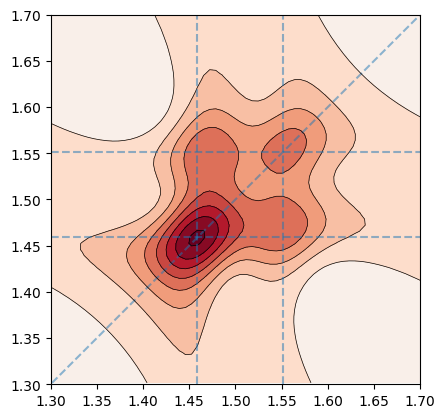

In [ ]:
vmin = spectrum_ch.real.min()
vmax = spectrum_ch.real.max()
v = max(np.abs(vmin), vmax)
plt.plot(np.diag(freq[0]), np.diag(freq[1]), linestyle='--', alpha=0.5)
plt.contour(freq[0], freq[1], spectrum_ch, colors='k',
            linewidths=0.5, vmin=-v, vmax=v)
plt.contourf(freq[0], freq[1], spectrum_ch, cmap='RdBu_r', vmin=-v, vmax=v)
[plt.axvline(x=eigval.real, linestyle='--', alpha=0.5) for eigval in eigvals]
[plt.axhline(y=eigval.real, linestyle='--', alpha=0.5) for eigval in eigvals]
plt.axis('square')
plt.xlim([1.3, 1.7])
plt.ylim([1.3, 1.7])